In [1]:
#Importando Librerias

from google.colab import drive
from pathlib import Path 
from PIL import Image
from PIL.ExifTags import TAGS
 
import pandas as pd
import folium
from folium import FeatureGroup, LayerControl, Map, Marker

from IPython.display import HTML, display

In [2]:
def progress(value, max=100):
    return HTML("""
        <progress
            value="{value}"
            max="{max}",
            style="width: 100%; content: attr(value)'%'"
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [3]:
#Conectando Colab con Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Sección nueva

In [4]:
#Función para extraer y limpiar los valores de Lat, Lon y Alt
def get_coord(GPS_info):
  raw_coord = [[clean_coord(ref) for ref in GPS_info[i]] for i in [2,4,6]]
  coord = [None]*3
  coord[0] = raw_coord[0][0] + raw_coord[0][1]/60 + raw_coord[0][2]/60**2
  coord[1] = -(raw_coord[1][0] + raw_coord[1][1]/60 + raw_coord[1][2]/60**2)
  coord[2] = raw_coord[2][0]
  return(coord)


#Función para limpiar los valores de Lat, Lon y Alt
def clean_coord(ref):
  try:
    return(ref[0]/ref[1])
  except:
    if ref > 10:
      return ref/10


#Función para extraer coordenadas dada la ruta de una imagen
# Input: Ruta de imagen
# Output: Tuple con coordenadas geográficas(Latitud, Longitud, Altitud) en grados decimales
def get_img_coord(img_dir):

  image = Image.open(img_dir)
  exifdata = image.getexif()
  image.close()
  GPS_info = exifdata.get(34853)      #`34853` es el TagID para extraer la `GPSInfo`
  img_coord = get_coord(GPS_info)
  return(img_coord)

In [5]:
#Función para general hipervínculo en HTML
def generate_link(url, tag):
  link = '<center><a href= {0} target="_blank"> {1} </a></center>'
  return(link.format(url, tag))

#String para consulta de archivos en Google Drive
gdrive_search = 'https://drive.google.com/drive/u/0/search?q='

In [11]:
#Consulta recursiva de archivos con extensión JPG
#Las imagenes serán enlistadas en la variable `raw_img_list`, de esta forma:
#  ['CLASE', 'NOMBRE DE IMAGEN'] ejemplo: ['AISLADOR', 'DJI_0577.JPG']

main_dir = 'gdrive/My Drive/Fotos_Drones_EPM/ELEMENTOS DE RED/'
raw_img_list = list(Path(main_dir).rglob("*.[Jj][Pp][Gg]"))
count_img_list = len(raw_img_list)

#Barra de progreso
progress_bar = display(progress(0, count_img_list), display_id=True)

#Creando objetos vacios [Diccionario y DataFrame]
img_dic = {}
img_df = pd.DataFrame({'img_name':[], 'category':[], 'lat':[], 'long':[], 'alt':[]})

#Cargando infromación de imagenes desde Drive a los objetos
for ii, img_dir in enumerate(raw_img_list):
  progress_bar.update(progress(ii, count_img_list))

  category, filename = str(img_dir).replace(main_dir,'').split('/')
  coord = get_img_coord(main_dir + category + '/' + filename)

  img_dic[filename] = {'category':category, 'coord':coord}
  img_df = img_df.append({'img_name':filename, 'category': category, \
                        'lat':coord[0], 'long':coord[1], 'alt':coord[2]},\
                        ignore_index=True)

In [12]:
 img_df

,img_name,category,lat,long,alt
0,DJI_0772.JPG,CUCHILLAS EN MAL ESTADO,6.179623,-75.369318,1980.3
1,DJI_0773.JPG,CUCHILLAS EN MAL ESTADO,6.179656,-75.369354,1977.4
2,DJI_0779.JPG,CUCHILLAS EN MAL ESTADO,6.179700,-75.368348,1975.3
3,DJI_0780.JPG,CUCHILLAS EN MAL ESTADO,6.179697,-75.368325,1975.3
4,DJI_0781.JPG,CUCHILLAS EN MAL ESTADO,6.179693,-75.368327,1976.2
...,...,...,...,...,...
903,E42831 (5).JPG,AISLADOR MAL ESTADO,5.468275,-74.930325,85526.0
904,E42831 (4).JPG,AISLADOR MAL ESTADO,5.468264,-74.930309,85536.0
905,E42831 (3).JPG,AISLADOR MAL ESTADO,5.468264,-74.930309,85536.0
906,DJI_0031.JPG,AISLADOR MAL ESTADO,6.037190,-75.197772,1324.2


In [13]:
# Función para crear la columna 'Estado' que define si está en buen o mal estado
def estado(x):
    if (x['category'] == 'POSTE'):
        return 'Good'
    elif (x['category'] == 'AISLADOR'):
        return 'Good'
    elif (x['category'] == 'CONDUCTOR'):
        return 'Good'
    elif (x['category'] == 'TRANSFORMADOR'):
        return 'Good'
    elif (x['category'] == 'VEGETACIÓN CONTACTO CON RED'):
        return 'Bad'
    elif (x['category'] == 'CORTACIRCUITO'):
        return 'Good'
    elif (x['category'] == 'DPS'):
        return 'Good'
    elif (x['category'] == 'AISLADOR MAL ESTADO'):
        return 'Bad'
    elif (x['category'] == 'CORTACIRCUITO MAL ESTADO'):
        return 'Bad'
    elif (x['category'] == 'POSTE MAL ESTADO'):
        return 'Bad'
    elif (x['category'] == 'OBJETOS SOBRE LA RED'):
        return 'Bad'
    elif (x['category'] == 'CUCHILLAS'):
        return 'Good'
    elif (x['category'] == 'CONDUCTOR MAL ESTADO'):
        return 'Bad'
    elif (x['category'] == 'CUCHILLAS EN MAL ESTADO'):
        return 'Bad'
    else:
        return 'Otros'

img_df['State']= img_df.apply(estado, axis=1)

In [14]:
# Función para crear la columna 'new_category' que define la categoría sin importar el estado
def def_category(x):
    if (x['category'] == 'POSTE'):
        return 'Poste'
    elif (x['category'] == 'AISLADOR'):
        return 'Aislador'
    elif (x['category'] == 'CONDUCTOR'):
        return 'Conductor'
    elif (x['category'] == 'TRANSFORMADOR'):
        return 'Transformador'
    elif (x['category'] == 'VEGETACIÓN CONTACTO CON RED'):
        return 'Vegetación contacto con red'
    elif (x['category'] == 'CORTACIRCUITO'):
        return 'Cortacircuito'
    elif (x['category'] == 'DPS'):
        return 'DPS'
    elif (x['category'] == 'AISLADOR MAL ESTADO'):
        return 'Aislador'
    elif (x['category'] == 'CORTACIRCUITO MAL ESTADO'):
        return 'Cortacircuito'
    elif (x['category'] == 'POSTE MAL ESTADO'):
        return 'Poste'
    elif (x['category'] == 'OBJETOS SOBRE LA RED'):
        return 'Objetos sobre la red'
    elif (x['category'] == 'CUCHILLAS'):
        return 'Cuchillas'
    elif (x['category'] == 'CONDUCTOR MAL ESTADO'):
        return 'Conductor'
    elif (x['category'] == 'CUCHILLAS EN MAL ESTADO'):
        return 'Cuchillas'
    else:
        return 'Otros'

img_df['Type of element']= img_df.apply(def_category, axis=1)

In [15]:
img_df2 = img_df.groupby(['Type of element','State'])['img_name'].count().reset_index()
img_df2

,Type of element,State,img_name
0,Aislador,Bad,84
1,Aislador,Good,249
2,Conductor,Bad,6
3,Conductor,Good,128
4,Cortacircuito,Bad,24
5,Cortacircuito,Good,35
6,Cuchillas,Bad,5
7,Cuchillas,Good,7
8,DPS,Good,30
9,Objetos sobre la red,Bad,7


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


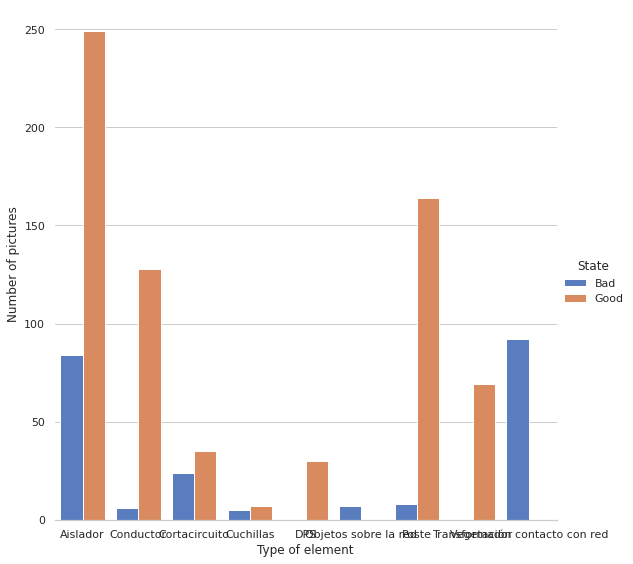

In [16]:
import seaborn as sns
sns.set(style="whitegrid")

g = sns.catplot(x="Type of element", y="img_name", hue="State", data=img_df2,
                height=8, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Number of pictures")

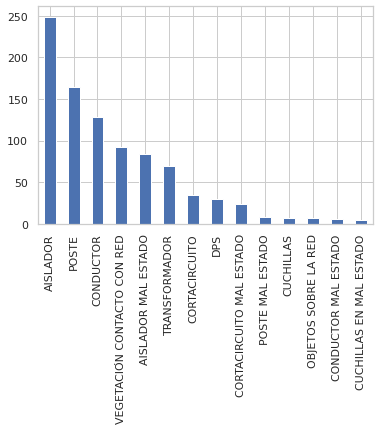

In [17]:
img_df['category'].value_counts().plot.bar()

In [20]:
#Determinando coordenadas centrales para visualizar el mapa 
lat_center = (max(img_df.lat) + min(img_df.lat))/2
long_center = (max(img_df.long) + min(img_df.long))/2

map = Map(location=[lat_center, long_center], zoom_start=11,
          width='100%', height='100%', left='10%',
          tiles='https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}', attr='Google')

good_layer = FeatureGroup(name='Elementos en Buen Estado')
bad_layer = FeatureGroup(name='Elementos en Mal Estado')

#Agregando Marcadores para cada Imagen
for img in img_dic.keys():
  category = img_dic[img]['category']
  search_link = generate_link(gdrive_search + img,'[Ver Imagen]')
  popup_html =  '<b>Archivo: </b>' + img + '</br>' + \
                '<b>Categoria: </b>' + category + '</br>'*2 + \
                search_link

  popup = folium.Popup(max_width=150, html=popup_html)

  #Icon library https://getbootstrap.com/docs/3.3/components/
  if 'MAL' in category:
    icon = folium.Icon(color='orange', icon='exclamation-sign')
    good_layer.add_child(Marker(img_dic[img]['coord'][0:2], popup = popup, icon=icon)).add_to(map)
  else:
    icon = folium.Icon(color='green', icon='ok-sign')
    bad_layer.add_child(Marker(img_dic[img]['coord'][0:2], popup = popup, icon=icon)).add_to(map)
  
  good_layer.add_to(map)
  bad_layer.add_to(map)

  LayerControl().add_to(map)

map

In [21]:
map.save('map.html')
